In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import sscCdi
import scipy

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft

%matplotlib widget

Finding shift between neighboor slices...
Shifting slices...


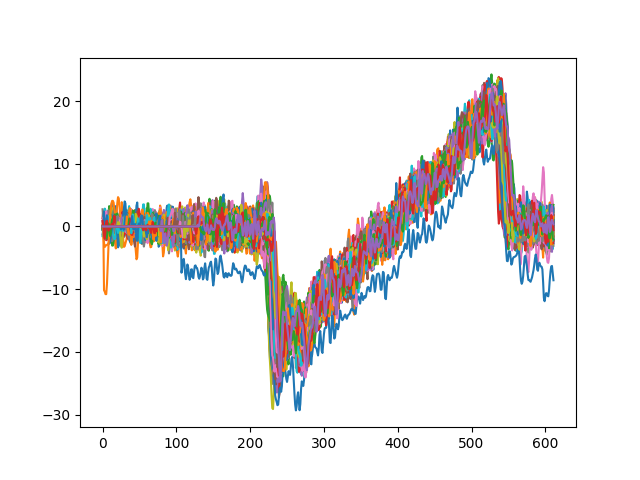

In [43]:
from skimage.transform import pyramid_gaussian
from skimage.restoration import unwrap_phase

def get_pyramid_complex_img(complex_img,downsampling = 2):
    frame_r = tuple(pyramid_gaussian(np.real(complex_img[i]), downscale=downsampling))[downsampling]
    frame_i = tuple(pyramid_gaussian(np.imag(complex_img[i]), downscale=downsampling))[downsampling]
    frame = frame_r + 1j*frame_i
    return frame

def vertical_phase_gradient(frame):
    gradient = np.gradient(frame)
    phase_gradient_y = np.imag( frame.conj() * gradient[0] / np.abs(frame)**2  )
    phase_gradient_y = np.sum(phase_gradient_y,axis=1)
    return phase_gradient_y



def alignment_variance_field(data,upsampling_factor=10,return_common_valid_region=False):
    
    neighbor_shifts = np.empty((data.shape[0],2))
    
    print('Finding shift between neighboor slices...')
    for i in range(0,data.shape[0]-1):

        local_variance1 = calculate_local_variance_field(data[i])
        local_variance2 = calculate_local_variance_field(data[i+1])
        
        shift, error, diffphase = phase_cross_correlation(local_variance1, local_variance2, upsample_factor=upsampling_factor)

        neighbor_shifts[i][0] = shift[0]
        neighbor_shifts[i][1] = shift[1]
        
    total_shift = np.cumsum(neighbor_shifts,axis=0)
    aligned_volume = np.zeros_like(data)
    aligned_volume[0] = data[0]
    
    print('Shifting slices...')
    for i in range(0,data.shape[0]-1):
        aligned_volume[i+1] = scipy.ndimage.shift(data[i+1],total_shift[i])
    
    if return_common_valid_region:
        print('Finding common useful region for whole volume...')
        masked_volume = np.where(aligned_volume==0,0,1)
        product = np.prod(np.abs(masked_volume),axis=0)
        where_null = np.where(np.abs(product) == 0,0,1)

        # plt.figure()
        # plt.imshow(np.abs(aligned_volume[-1]))

        aligned_volume[:] = np.where(where_null==1,aligned_volume,0) 

    print('Done')
    return aligned_volume, neighbor_shifts

def shift_2d_replace(data, dx, dy, constant=False):
    """
    Shifts the array in two dimensions while setting rolled values to constant
    :param data: The 2d numpy array to be shifted
    :param dx: The shift in x
    :param dy: The shift in y
    :param constant: The constant to replace rolled values with
    :return: The shifted array with "constant" where roll occurs
    """
    shifted_data = np.roll(data, dx, axis=1)
    if dx < 0:
        shifted_data[:, dx:] = constant
    elif dx > 0:
        shifted_data[:, 0:dx] = constant

    shifted_data = np.roll(shifted_data, dy, axis=0)
    if dy < 0:
        shifted_data[dy:, :] = constant
    elif dy > 0:
        shifted_data[0:dy, :] = constant
    return shifted_data


def get_gaussian_pyramid(frame,layers=2):

    from skimage.transform import pyramid_gaussian

    img_real = np.real(frame)
    img_imag = np.imag(frame)

    pyramid_real = tuple(pyramid_gaussian(img_real,downscale=2,max_layer=layers-1))
    pyramid_imag = tuple(pyramid_gaussian(img_imag,downscale=2,max_layer=layers-1))
    
    pyramid = []
    for R, I in zip(pyramid_real,pyramid_imag):
        pyramid.append(R+1j*I)

    return pyramid

def calculate_local_variance_field(matrix):
    
    gradient = np.gradient(matrix)
    del_x = gradient[1]
    del_y = gradient[0]
        
    return np.sqrt(np.abs(del_x)**2 + np.abs(del_y)**2)

def remove_black_borders(aligned_volume):

    not_null = np.argwhere(np.abs(aligned_volume[0]))

    # Bounding box of non-black pixels.
    x0, y0 = not_null.min(axis=0)
    x1, y1 = not_null.max(axis=0) + 1   # slices are exclusive at the top

    # Get the contents of the bounding box.
    cropped_aligned_volume = aligned_volume[:,x0:x1, y0:y1]

    return cropped_aligned_volume


from skimage.transform import pyramid_gaussian
from skimage.restoration import unwrap_phase
from scipy.ndimage import center_of_mass

def calculate_curve_ctr_of_mass(curve):
    ctr_mass = np.dot(curve,positions)/np.sum(curve)
    return ctr_mass

def get_pyramid_complex_img(complex_img,downsampling = 2):
    frame_r = tuple(pyramid_gaussian(np.real(complex_img[i]), downscale=downsampling))[downsampling]
    frame_i = tuple(pyramid_gaussian(np.imag(complex_img[i]), downscale=downsampling))[downsampling]
    frame = frame_r + 1j*frame_i
    return frame

def vertical_phase_gradient(frame):
    gradient = np.gradient(frame)
    phase_gradient_y = np.imag( frame.conj() * gradient[0] / np.abs(frame)**2  )
    phase_gradient_y = np.sum(phase_gradient_y,axis=1)
    return phase_gradient_y

def overlap_curves(data):

    neighbor_shifts = np.empty((data.shape[0],1))

    print('Finding shift between neighboor slices...')
    for i in range(0,data.shape[0]-1):

        shift, error, diffphase = phase_cross_correlation(data[i], data[i+1], upsample_factor=10)
        neighbor_shifts[i][0] = shift[0]

    total_shift = np.cumsum(neighbor_shifts,axis=0)
    aligned_curves = np.zeros_like(data)
    aligned_curves[0] = data[0]

    print('Shifting slices...')
    for i in range(0,data.shape[0]-1):
        aligned_curves[i+1] = scipy.ndimage.shift(data[i+1],total_shift[i])

    plt.figure()
    for i in range(0,data.shape[0]-1):
        plt.plot(aligned_curves[i])
        
    return aligned_curves, total_shift, neighbor_shifts

aligned_curves, total_shift, neighbor_shifts =  overlap_curves(data)

In [4]:
# path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/temp/2023-05-16-15h38m_glass_sphere_phase_cropped_sinogram.npy"
# data = np.load(path)[0:10]

path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/2023-05-16-15h38m_glass_sphere.hdf5"
data = h5py.File(path,'r')['recon/object'][()]
angles = h5py.File(path,'r')['recon/angles'][()][:,0::2]

print(angles.shape)

# mean = np.mean(data,axis=0)
# plt.figure()
# plt.imshow(np.abs(mean))

data=data[:,1350:-1300,1200:-1400]

(214, 2)


In [5]:
from sscCdi import sort_angles
from sscCdi import reorder_slices_low_to_high_angle

sorted_angles = sort_angles(angles) # input colums with frame number and angle in rad
data = reorder_slices_low_to_high_angle(data, sorted_angles)

In [6]:
aligned_volume, neighbor_shifts = alignment_variance_field(data,return_common_valid_region=True)

Finding shift between neighboor slices...
Shifting slices...
Finding common useful region for whole volume...
Done


In [8]:
sscCdi.misc.deploy_visualizer(np.angle(aligned_volume),title='sample',cmap='gray')

In [58]:
cropped_aligned_volume = remove_black_borders(aligned_volume)

idx_to_delete = [28,30,45,49,65,66,91,113]
cropped_aligned_volume = np.delete(cropped_aligned_volume,idx_to_delete,axis=0)

# sscCdi.misc.deploy_visualizer(np.abs(cropped_aligned_volume),title='sample',cmap='gray')
sscCdi.misc.deploy_visualizer(np.angle(cropped_aligned_volume),title='sample',cmap='gray')

0
50
100
150
200
Finding shift between neighboor slices...
Shifting slices...


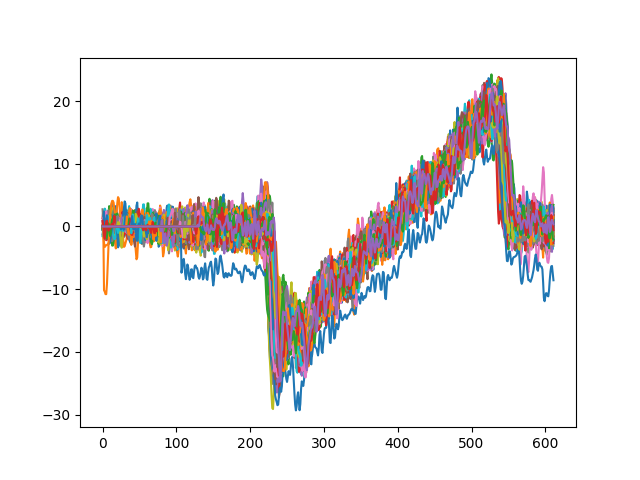

In [45]:
curves = []

# plt.figure()
for i in range(cropped_aligned_volume.shape[0]):
    if i%50==0: print(i)
   
    frame = cropped_aligned_volume[i]
    # frame = get_pyramid_complex_img(complex_obj,downsampling = 2)

    phase_gradient_y = vertical_phase_gradient(frame)
    curves.append(phase_gradient_y)
    # plt.plot(phase_gradient_y)
    
data = np.asarray(curves)

aligned_curves, total_shift, neighbor_shifts = overlap_curves(data)



In [59]:
aligned_volume2 = np.zeros_like(cropped_aligned_volume)
aligned_volume2[0] = cropped_aligned_volume[0]

print('Shifting slices...')
for i in range(0,cropped_aligned_volume.shape[0]-1):
    aligned_volume2[i+1] = scipy.ndimage.shift(cropped_aligned_volume[i+1],[total_shift[i],0])
    
aligned_volume2 = remove_black_borders(aligned_volume2)    
    
sscCdi.misc.deploy_visualizer(np.angle(aligned_volume2),title='sample',cmap='gray')

Shifting slices...


In [60]:
sscCdi.misc.deploy_visualizer(np.angle(aligned_volume2),title='sample',cmap='gray',axis=2)

In [53]:
sscCdi.misc.deploy_visualizer(np.angle(cropped_aligned_volume),title='sample',cmap='gray',axis=2)

In [67]:
from sscCdi import unwrap_in_parallel, equalize_frames_parallel

unwrapped_volume = unwrap_in_parallel(np.angle(aligned_volume2))

unwrapped_volume = unwrapped_volume[:,100::,:]

sscCdi.misc.deploy_visualizer(unwrapped_volume,title='sample',cmap='gray')

Using 32 parallel processes


100%|██████████| 206/206 [00:02<00:00, 92.92it/s] 


(206, 612, 586)
(206, 512, 586)


In [76]:
dic = {}
dic["bad_frames_before_unwrap"] = [28,30,45,49,65,66,91,113]
dic["equalize_gradient"] = [True,[0,500,0,50]]
dic["equalize_global_offset"] = False
dic["equalize_invert"] = True
dic["equalize_local_offset"] = [0,500,0,50]
dic["equalize_outliers"] = 0

equalized_sinogram = equalize_frames_parallel(unwrapped_volume,dic["equalize_invert"],dic["equalize_gradient"],dic["equalize_outliers"],dic["equalize_global_offset"], dic["equalize_local_offset"])
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray')

Sinogram shape to unwrap:  (206, 512, 586)
Using 32 parallel processes


100%|██████████| 206/206 [00:02<00:00, 75.62it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old  -0.5275234209848894 -4.908481739760365 1.038223437685827 6.98492861513202 6.634481943072043
New  -0.9993508 -5.02219295501709 1.1468363 7.315865516662598 7.893155


In [77]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=2)

In [78]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=1)

In [31]:
# path = '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/glass_sphere/temp/2023-05-16-15h38m_glass_sphere_phase_wiggle_sinogram.npy'
# only_wiggle_alignment = np.load(path)
# sscCdi.misc.deploy_visualizer(only_wiggle_alignment,title='sample',cmap='gray',axis=0)

In [74]:
from sscCdi import wiggle

dic = {}
dic["CPUs"] = 32
dic["project_angles_to_regular_grid"] = False
dic["bad_frames_before_wiggle"] = [] 
dic["wiggle_reference_frame"] = 100

aligned_sinogram, wiggle_cmas = wiggle(dic,equalized_sinogram)

sscCdi.misc.deploy_visualizer(aligned_sinogram,title='sample',cmap='gray',axis=1,limits)

ssc-radon: creating 206x512x586 shared arrays (tomogram)
ssc-radon: creating 206x512x586 shared arrays (tomogram)
	Finished vertical wiggle. Starting horizontal wiggle...
ssc-radon: creating 206x512x586 shared arrays (tomogram)


In [75]:
sscCdi.misc.deploy_visualizer(aligned_sinogram,title='sample',cmap='gray',axis=2)

In [79]:
data2 = unwrap_in_parallel(np.angle(data))
data2 = equalize_frames_parallel(data2,dic["equalize_invert"],dic["equalize_gradient"],dic["equalize_outliers"],dic["equalize_global_offset"], dic["equalize_local_offset"])
data2, wiggle_cmas = wiggle(dic,data2)

sscCdi.misc.deploy_visualizer(aligned_sinogram,title='sample',cmap='gray',axis=1)
sscCdi.misc.deploy_visualizer(aligned_sinogram,title='sample',cmap='gray',axis=2)

Using 32 parallel processes


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed